In [30]:
import pandas as pd
from pyopenms import MzMLFile, MSExperiment, OnDiscMSExperiment
import numpy as np
import re
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [4]:
#df_hydroxy_all = pd.read_csv("../../data/diann_results/dia_nn_results_filtered/report_filtered_hydroxy_all_spectra.tsv", delimiter="\t")
mapping_df_all = pd.read_csv("../../data/230928_JL_Immonium_ions_Modified_DIA_id_mapping.csv", index_col="renamed_id")
mapping_df_subset = pd.read_csv("../../data/workflow_test_tolerance_snr3_10ppm/spectrum_id_mapping_Y(UniMod:21).csv", index_col="renamed_id")

In [5]:
def get_id_number(id_string):
    return int(re.findall("[0-9]+", id_string)[-1])

def get_id_number_from_name(spectrum):
    return re.findall("scan=[0-9]+",spectrum.getMetaValue("spectrum title"))[0][5:]

In [6]:
def get_higher_energy_scan_id(id_string):
    id_number = get_id_number(id_string)
    higher_energy_id_number = id_number + 36
    return f"controllerType=0 controllerNumber=1 scan={higher_energy_id_number}"

In [7]:
def get_df_with_original_and_higher_energy_id_mapped(df, exp, mapping_df):
    df = df.copy()
    ms2_spectra = np.array([spectrum for spectrum in exp.getSpectra() if spectrum.getMSLevel() == 2])
    ms2_spectra_in_df = ms2_spectra[df["MS2.Scan"].to_numpy()]
    df.insert(len(df.columns), "remapped_ids", [s.getNativeID() for s in ms2_spectra_in_df])
    df.insert(len(df.columns), "original_ids", [mapping_df.loc[remapped_id]["original_id"] for remapped_id in df["remapped_ids"]])
    higher_energy_id_number = np.array([get_id_number(get_higher_energy_scan_id(id)) for id in df["original_ids"]])
    df.insert(len(df.columns), "higher_energy_ids", higher_energy_id_number)
    return df

In [8]:
exp_all = MSExperiment()
MzMLFile().load("../../data/230928_JL_Immonium_ions_Modified_DIA_lower_energy.mzML", exp_all)

In [9]:
exp_subset = MSExperiment()
MzMLFile().load("../../data/workflow_test_tolerance_snr3_10ppm/lower_energy_windows_Y(UniMod:21).mzML", exp_subset)

In [10]:
df_phospho_all = get_df_with_original_and_higher_energy_id_mapped(pd.read_csv("../../data/diann_results/dia_nn_results_filtered/report_filtered_phospho_all_spectra.tsv", delimiter="\t"), exp_all, mapping_df_all)

df_phospho_subset = get_df_with_original_and_higher_energy_id_mapped(pd.read_csv("../../data/diann_results/dia_nn_results_filtered/report_Y(UniMod:21).tsv", delimiter="\t"), exp_subset, mapping_df_subset)

In [11]:
phospho_precursors_all = df_phospho_all[df_phospho_all["Modified.Sequence"].str.contains("UniMod:21")]
len(phospho_precursors_all)

373

In [12]:
len(df_phospho_all)

1368

In [9]:
df_hydroxy_all = get_df_with_original_and_higher_energy_id_mapped(df_hydroxy_all, exp_all, mapping_df_all)
hydroxy_precursors_all = df_hydroxy_all[df_hydroxy_all["Modified.Sequence"].str.contains("UniMod:35")]
len(hydroxy_precursors_all)

NameError: name 'df_hydroxy_all' is not defined

In [13]:
def get_detected_ions_for_mod(ions_df, amino_acid, mod_name):
    ions_df = ions_df.copy()
    ions_df.insert(len(ions_df.columns), "id_numbers", [get_id_number(id) for id in ions_df["spectrum_id"]])
    return ions_df[np.logical_and(ions_df["amino_acid"] == amino_acid, ions_df["mod_name"] == mod_name)]

In [14]:
detected_ions_df = pd.read_csv("../../data/workflow_test_tolerance_snr3_10ppm/detected_ions.csv")

phospho_detected = get_detected_ions_for_mod(detected_ions_df, "Tyrosine", "Phospho")
detected_ids_phopspho = phospho_detected["id_numbers"]

In [15]:
len(detected_ions_df[detected_ions_df["mod_name"] != "unmodified"]["spectrum_id"].unique())

36776

In [13]:
hydroxy_detected = get_detected_ions_for_mod(detected_ions_df, "Proline", "Oxidation")
detected_ids_hydroxy = hydroxy_detected["id_numbers"]

In [14]:
len(phospho_detected), len(hydroxy_detected)

(26571, 17075)

In [16]:
in_phospho_detected_all = set(phospho_precursors_all["higher_energy_ids"].to_numpy()).intersection(set(detected_ids_phopspho))
not_in_phospho_detected_all = set(phospho_precursors_all["higher_energy_ids"].to_numpy()).difference(set(detected_ids_phopspho))

In [31]:
def sankey_for_analysis_on_all_spectra(df_all, mod_unimod, amino_acid, mod_name):
  num_precursors_all = len(df_all)
  df_precursors_mod = df_all[df_all["Modified.Sequence"].str.contains(mod_unimod)]
  num_precursors_mod = len(df_precursors_mod)

  detected_mod_df = get_detected_ions_for_mod(detected_ions_df, amino_acid, mod_name)
  result_in_detected_windows_df = df_precursors_mod[df_precursors_mod["higher_energy_ids"].isin(detected_mod_df["id_numbers"])]
  result_not_in_detected_windows_df = df_precursors_mod[~df_precursors_mod["higher_energy_ids"].isin(detected_mod_df["id_numbers"])]
  num_in_detected_windows = len(result_in_detected_windows_df)
  num_not_in_detected_windows = len(result_not_in_detected_windows_df)

  get_from_synthetic_protein_df = lambda input_df: input_df[input_df["Protein.Ids"].str.contains("X0000")]

  from_synthetic_protein_df = get_from_synthetic_protein_df(df_precursors_mod)
  num_detected_windows_synthetic = len(get_from_synthetic_protein_df(result_in_detected_windows_df))
  num_detected_windows_not_synthetic = len(result_in_detected_windows_df) - num_detected_windows_synthetic
  num_not_detected_windows_synthetic = len(get_from_synthetic_protein_df(result_not_in_detected_windows_df))
  num_not_detected_windows_not_synthetic = len(result_not_in_detected_windows_df) - num_not_detected_windows_synthetic

  num_kmod = from_synthetic_protein_df["Protein.Ids"].str.contains("X00001").sum()
  num_pmod = from_synthetic_protein_df["Protein.Ids"].str.contains("X00002").sum()
  num_ymod = from_synthetic_protein_df["Protein.Ids"].str.contains("X00005").sum()


  fig = go.Figure(data=[go.Sankey(
      node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = [f"all precursors<br>{num_precursors_all}",
                 f"phospho<br>{num_precursors_mod}",
                 f"unmod<br>{num_precursors_all - num_precursors_mod}",
                 f"in phospho ion window<br>{num_in_detected_windows}",
                 f"not in phospho ion window<br>{num_not_in_detected_windows}",
                 f"from synthetic protein<br>{num_detected_windows_synthetic + num_not_detected_windows_synthetic}",
                 f"not from synthetic protein<br>{num_detected_windows_not_synthetic + num_not_detected_windows_not_synthetic}",
                 f"from Kmod<br>{num_kmod}",
                 f"from Pmod<br>{num_pmod}",
                 f"from Ymod<br>{num_ymod}"],
        color = "blue"
      ),
      link = dict(
        source = [0, 0, 1, 1, 3, 4, 3, 4, 5, 5, 5], # indices correspond to labels, eg A1, A2, A1, B1, ...
        target = [1, 2, 3, 4, 5, 5, 6, 6, 7, 8, 9],
        value = [num_precursors_mod,
                 num_precursors_all - num_precursors_mod,
                 num_in_detected_windows,
                 num_not_in_detected_windows,
                 num_detected_windows_synthetic,
                 num_not_detected_windows_synthetic,
                 num_detected_windows_not_synthetic,
                 num_not_detected_windows_not_synthetic,
                 num_kmod, num_pmod, num_ymod]
    ))])

  fig.update_layout(title_text="Phospho all spectra", font_size=14, font_color="black")
  fig.show()

In [32]:
sankey_for_analysis_on_all_spectra(df_phospho_all, "UniMod:21", "Tyrosine", "Phospho")

In [35]:
def sankey_for_analysis_on_subset_spectra_comparison_all_matching_windows(df_all, df_subset, mod_unimod):# amino_acid, mod_name):
  num_subset = len(df_subset)
  subset_matching_windows = df_subset.merge(df_all, on="original_ids", suffixes=("_subset", "_all"))
  subset_matching_windows_precursors = subset_matching_windows[subset_matching_windows["Precursor.Id_subset"] == subset_matching_windows["Precursor.Id_all"]]
  num_matching_windows_precursors = len(subset_matching_windows_precursors)
  # subset_matching_precursors = df_subset.merge(df_all, on="Precursor.Id", suffixes=("_subset", "_all"))
  # num_matching_precursors = len(subset_matching_precursors)


  # num_precursors_all = len(df_all)
  df_precursors_mod = subset_matching_windows_precursors[subset_matching_windows_precursors["Modified.Sequence_subset"].str.contains(mod_unimod)]
  df_precursors_unmod = subset_matching_windows_precursors[~subset_matching_windows_precursors["Modified.Sequence_subset"].str.contains(mod_unimod)]
  num_precursors_mod = len(df_precursors_mod)
  num_precursors_unmod = len(df_precursors_unmod)

  # detected_mod_df = get_detected_ions_for_mod(detected_ions_df, amino_acid, mod_name)
  # result_in_detected_windows_df = df_precursors_mod[df_precursors_mod["higher_energy_ids"].isin(detected_mod_df["id_numbers"])]
  # result_not_in_detected_windows_df = df_precursors_mod[~df_precursors_mod["higher_energy_ids"].isin(detected_mod_df["id_numbers"])]
  # num_in_detected_windows = len(result_in_detected_windows_df)
  # num_not_in_detected_windows = len(result_not_in_detected_windows_df)

  from_synthetic_protein_df = df_precursors_mod[df_precursors_mod["Protein.Ids_subset"].str.contains("X0000")]
  num_mod_synthetic = len(from_synthetic_protein_df)
  num_mod_not_synthetic = num_precursors_mod - num_mod_synthetic

  num_kmod = from_synthetic_protein_df["Protein.Ids_subset"].str.contains("X00001").sum()
  num_pmod = from_synthetic_protein_df["Protein.Ids_subset"].str.contains("X00002").sum()
  num_ymod = from_synthetic_protein_df["Protein.Ids_subset"].str.contains("X00005").sum()


  fig = go.Figure(data=[go.Sankey(
      node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = [f"subset precursors<br>{num_subset}",
                 f"matching all-spectra result<br>{num_matching_windows_precursors}",
                 f"not_matching<br>{num_subset - num_matching_windows_precursors}",
                 f"phospho<br>{num_precursors_mod}",
                 f"unmod<br>{num_precursors_unmod}",
                 f"from synthetic protein<br>{num_mod_synthetic}",
                 f"not from synthetic protein<br>{num_mod_not_synthetic}",
                 f"from Kmod<br>{num_kmod}",
                 f"from Pmod<br>{num_pmod}",
                 f"from Ymod<br>{num_ymod}"
                 ],
        color = "blue"
      ),
      link = dict(
        source = [0, 0, 1, 1, 3, 3, 5, 5, 5], # indices correspond to labels, eg A1, A2, A1, B1, ...
        target = [1, 2, 3, 4, 5, 6, 7, 8, 9],
        value = [num_matching_windows_precursors, num_subset - num_matching_windows_precursors,
                 num_precursors_mod, num_precursors_unmod,
                 num_mod_synthetic,
                 num_mod_not_synthetic,
                 num_kmod, num_pmod, num_ymod]
    ))])

  fig.update_layout(title_text="Phospho subset matching precursors", font_size=14, font_color="black")
  fig.show()

In [36]:
sankey_for_analysis_on_subset_spectra_comparison_all_matching_windows(df_phospho_all, df_phospho_subset, "UniMod:21")

In [38]:
def sankey_for_analysis_on_subset_spectra_filtered_qvalue(df_all, df_subset, mod_unimod):# amino_acid, mod_name):
  num_subset = len(df_subset)
  subset_matching_windows = df_subset.merge(df_all, on="original_ids", suffixes=("_subset", "_all"))
  subset_matching_windows_precursors = subset_matching_windows[subset_matching_windows["Precursor.Id_subset"] == subset_matching_windows["Precursor.Id_all"]]

  qvalue = subset_matching_windows_precursors["Q.Value_subset"].max()
  subset_filtered = df_subset[df_subset["Q.Value"] < qvalue]
  num_passing_qvalue = len(subset_filtered)
  num_not_qvalue = num_subset - num_passing_qvalue

  # num_precursors_all = len(df_all)
  df_precursors_mod = subset_filtered[subset_filtered["Modified.Sequence"].str.contains(mod_unimod)]
  df_precursors_unmod = subset_filtered[~subset_filtered["Modified.Sequence"].str.contains(mod_unimod)]
  num_precursors_mod = len(df_precursors_mod)
  num_precursors_unmod = len(df_precursors_unmod)

  from_synthetic_protein_df = df_precursors_mod[df_precursors_mod["Protein.Ids"].str.contains("X0000")]
  num_mod_synthetic = len(from_synthetic_protein_df)
  num_mod_not_synthetic = num_precursors_mod - num_mod_synthetic
  num_kmod = from_synthetic_protein_df["Protein.Ids"].str.contains("X00001").sum()
  num_pmod = from_synthetic_protein_df["Protein.Ids"].str.contains("X00002").sum()
  num_ymod = from_synthetic_protein_df["Protein.Ids"].str.contains("X00005").sum()


  fig = go.Figure(data=[go.Sankey(
      node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = [f"subset precursor entries<br>{num_subset}",
                 f"passing qvalue of {qvalue}<br>{num_passing_qvalue}",
                 f"not passing qvalue<br>{num_not_qvalue}",
                 f"phospho<br>{num_precursors_mod}",
                 f"unmod<br>{num_precursors_unmod}",
                 f"from synthetic protein<br>{num_mod_synthetic}",
                 f"not from synthetic protein<br>{num_mod_not_synthetic}",
                 f"from Kmod<br>{num_kmod}",
                 f"from Pmod<br>{num_pmod}",
                 f"from Ymod<br>{num_ymod}"
                 ],
        color = "blue"
      ),
      link = dict(
        source = [0, 0, 1, 1, 3, 3, 5, 5, 5], # indices correspond to labels, eg A1, A2, A1, B1, ...
        target = [1, 2, 3, 4, 5, 6, 7, 8, 9],
        value = [num_passing_qvalue,
                 num_not_qvalue,
                 num_precursors_mod, num_precursors_unmod,
                 num_mod_synthetic,
                 num_mod_not_synthetic,
                 num_kmod, num_pmod, num_ymod]
    ))])

  fig.update_layout(title_text="Phospho subset filered q-value", font_size=14, font_color="black")
  fig.show()

In [39]:
sankey_for_analysis_on_subset_spectra_filtered_qvalue(df_phospho_all, df_phospho_subset, "UniMod:21")

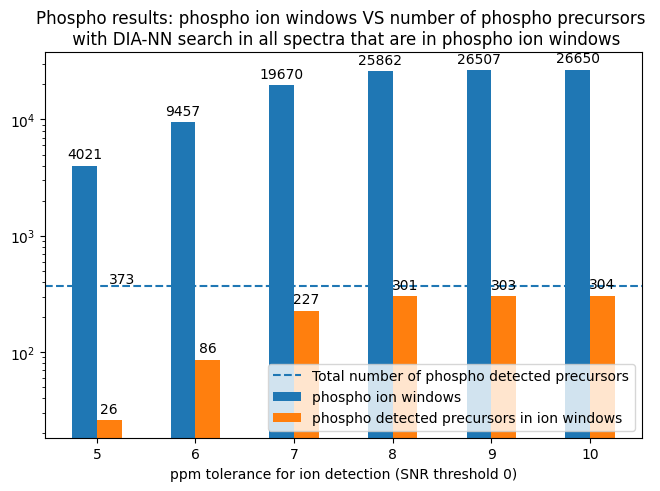

In [17]:
phospho_ion_windows_per_ppm = []
phospho_precursors_in_ion_windows_per_ppm = []
ppms = np.array([5, 6, 7, 8, 9, 10])
for ppm in ppms:
    df_ppm = pd.read_csv(f"../../data/result_csvs/230928_JL_Immonium_ions_Modified_DIA.mzML_diagnostic_ions_ppm_tolerance_{ppm}_snr_threshold_0.csv")
    phospho_detected_ppm = get_detected_ions_for_mod(df_ppm, "Tyrosine", "Phospho")
    detected_ids_phopspho_ppm = phospho_detected_ppm["id_numbers"]
    in_phospho_detected_all_ppm = set(phospho_precursors_all["higher_energy_ids"].to_numpy()).intersection(set(detected_ids_phopspho_ppm))
    phospho_ion_windows_per_ppm.append(len(phospho_detected_ppm))
    phospho_precursors_in_ion_windows_per_ppm.append(len(in_phospho_detected_all_ppm))

width = 0.25
fig, ax = plt.subplots(layout='constrained')

ax.bar_label(ax.bar(ppms, phospho_ion_windows_per_ppm, width, label="phospho ion windows"), padding=3)

ax.bar_label(ax.bar(ppms + width, phospho_precursors_in_ion_windows_per_ppm, width, label=f"phospho detected precursors in ion windows"), padding=3)
ax.axhline(len(phospho_precursors_all), label="Total number of phospho detected precursors", linestyle="dashed")
ax.text(ppms[0] + width, len(phospho_precursors_all) + 20, len(phospho_precursors_all))

ax.set_xlabel("ppm tolerance for ion detection (SNR threshold 0)")
ax.set_title("Phospho results: phospho ion windows VS number of phospho precursors \n with DIA-NN search in all spectra that are in phospho ion windows")
plt.legend(loc="lower right")
ax.set_xticks(ppms + width/2, ppms)
ax.set_yscale("log")
plt.savefig("../../data/plots/phospho_results_all_spectra.png")
plt.show()

In [18]:
len(not_in_phospho_detected_all)

70

In [19]:
len(in_phospho_detected_all)

303

In [37]:
tolerance_margin = 216.042 * 10 / 1e6
print(216.042 - tolerance_margin, 216.042 + tolerance_margin)

216.03983958 216.04416042


In [39]:
def ion_detection(spectrum):
    spectrum_mz, intensities = spectrum.get_peaks()
    lower_border = np.searchsorted(spectrum_mz, 216.042 - tolerance_margin, side="left")
    higher_border = np.searchsorted(spectrum_mz, 216.042 + tolerance_margin, side="right")

    detected_peaks_mz = spectrum_mz[lower_border:higher_border]
    detected_peaks_intensities = intensities[lower_border:higher_border]
    if len(detected_peaks_mz) == 0:
        return None, 0
    max_peak_idx = np.argmax(detected_peaks_intensities)
    max_peak_mz = detected_peaks_mz[max_peak_idx]
    max_peak_intensity = detected_peaks_intensities[max_peak_idx]
    return max_peak_mz, max_peak_intensity

In [48]:
for id_number in not_in_phospho_detected_all:
    s = od_exp.getSpectrumByNativeId(f"controllerType=0 controllerNumber=1 scan={id_number}")
    max_peak_mz, max_peak_intensity = ion_detection(s)
    if max_peak_mz is None:
        print(f"None found for {id_number}")
        print(detected_ions_df[detected_ions_df["spectrum_id"] == s.getNativeID()])
        continue
    print(id_number, max_peak_intensity < s.get_peaks()[1].mean())

None found for 63363
Empty DataFrame
Columns: [spectrum_id, amino_acid, mod_name, letter_and_unimod_format_mod, type, theoretical_mz, detected_mz, detected_intensity]
Index: []
69126 True
None found for 68617
Empty DataFrame
Columns: [spectrum_id, amino_acid, mod_name, letter_and_unimod_format_mod, type, theoretical_mz, detected_mz, detected_intensity]
Index: []
62477 True
68749 True
70797 True
None found for 84240
Empty DataFrame
Columns: [spectrum_id, amino_acid, mod_name, letter_and_unimod_format_mod, type, theoretical_mz, detected_mz, detected_intensity]
Index: []
None found for 76942
Empty DataFrame
Columns: [spectrum_id, amino_acid, mod_name, letter_and_unimod_format_mod, type, theoretical_mz, detected_mz, detected_intensity]
Index: []
84376 True
78618 True
None found for 94235
Empty DataFrame
Columns: [spectrum_id, amino_acid, mod_name, letter_and_unimod_format_mod, type, theoretical_mz, detected_mz, detected_intensity]
Index: []
68251 True
None found for 59933
Empty DataFrame
C

In [54]:
def plot_phospho_ions_behaviour_for_spectrum_id_within_ms1_window(s_id_number):
    current_ms1_intensities = []
    previous_ms1_intensities = []
    spectrum_idcs = []
    phospho_precursor_idcs = []

    initial_spectrum_idx = [i[0] for i in enumerate(spectra_all2) if i[1].getNativeID() == f"controllerType=0 controllerNumber=1 scan={s_id_number}"][0]
    ms1_spectrum_idx = exp2.getPrecursorSpectrum(initial_spectrum_idx)
    spectrum_idx = ms1_spectrum_idx + 1

    current_spectrum = spectra_all2[spectrum_idx]
    while current_spectrum.getMSLevel() == 2:
        if current_spectrum.getPrecursors()[0].getMetaValue("collision energy") == 50:
            current_ms1_intensity = ion_detection(current_spectrum)[1]
            previous_ms1_intensity = ion_detection(spectra_all2[spectrum_idx - 73])[1]
            current_ms1_intensities.append(current_ms1_intensity)
            previous_ms1_intensities.append(previous_ms1_intensity)
            spectrum_idcs.append(spectrum_idx)
            if get_id_number(current_spectrum.getNativeID()) in phospho_precursors_all["higher_energy_ids"].to_numpy():
                phospho_precursor_idcs.append(spectrum_idx)

        spectrum_idx += 1
        current_spectrum = spectra_all2[spectrum_idx]

    plt.figure(figsize=(6, 4))
    plt.plot(spectrum_idcs, previous_ms1_intensities, label="immonium ions in windows for previous MS1 window", marker="o", color="orange")
    plt.plot(spectrum_idcs, current_ms1_intensities, label="immonium ions in windows for current MS1 window", marker="o")
    
    for precursor_idx in phospho_precursor_idcs:
        color = "g" if get_id_number(spectra_all2[precursor_idx].getNativeID()) in in_phospho_detected_all else "r"
        plt.axvline(precursor_idx, color=color)
    #plt.axvline(initial_spectrum_idx, color="violet")
    plt.legend(loc="upper right")


In [23]:
def plot_phospho_ions_behaviour_for_spectrum_id_within_mz_range(s_id_number):
    intensities = []
    spectrum_idcs = []
    phospho_precursor_idcs = []

    initial_spectrum_idx = [i[0] for i in enumerate(spectra_all2) if i[1].getNativeID() == f"controllerType=0 controllerNumber=1 scan={s_id_number}"][0]
    spectrum_idx = initial_spectrum_idx % 73

    while spectrum_idx < len(spectra_all2):
        current_spectrum = spectra_all2[spectrum_idx]
        
        intensity = ion_detection(current_spectrum)[1]
        intensities.append(intensity)
        spectrum_idcs.append(spectrum_idx)
        if get_id_number(current_spectrum.getNativeID()) in phospho_precursors_all["higher_energy_ids"].to_numpy():
            phospho_precursor_idcs.append(spectrum_idx)

        spectrum_idx += 73

    plt.figure(figsize=((16, 5)))
    plt.plot(spectrum_idcs, intensities)
    
    for precursor_idx in phospho_precursor_idcs:
        color = "g" if get_id_number(spectra_all2[precursor_idx].getNativeID()) in in_phospho_detected_all else "r"
        plt.axvline(precursor_idx, color=color)

    print([get_id_number(spectra_all2[precursor_idx].getNativeID()) for precursor_idx in phospho_precursor_idcs])

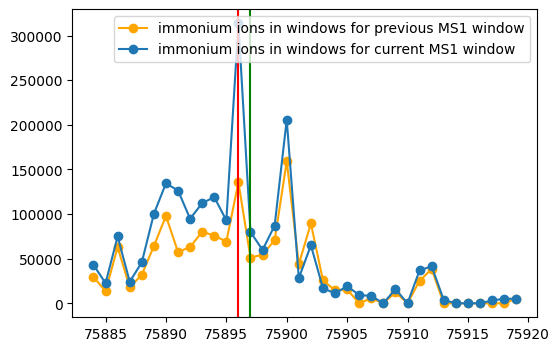

In [55]:
plot_phospho_ions_behaviour_for_spectrum_id_within_ms1_window(75897)

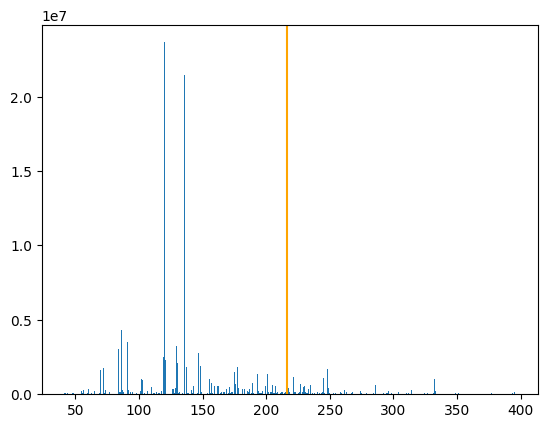

In [38]:
plt.bar(*od_exp.getSpectrumByNativeId("controllerType=0 controllerNumber=1 scan=75897").get_peaks())
plt.axvline(216.042, color="orange")

In [30]:
detected_ions_df[detected_ions_df["spectrum_id"] == "controllerType=0 controllerNumber=1 scan=75897"]

,spectrum_id,amino_acid,mod_name,type,theoretical_mz,detected_mz,detected_intensity
283832,controllerType=0 controllerNumber=1 scan=75897,Arginine,unmodified,IM-59,70.0651,70.064606,1621460.90
283833,controllerType=0 controllerNumber=1 scan=75897,Lysine,unmodified,IM-NH3,84.0808,84.080124,3055120.80
283834,controllerType=0 controllerNumber=1 scan=75897,Lysine,unmodified,alpha-amino-epsilon-caprolactam,129.1022,129.101196,3252772.50
283835,controllerType=0 controllerNumber=1 scan=75897,Lysine,Acetyl,IM,143.1179,143.116684,535526.44
283836,controllerType=0 controllerNumber=1 scan=75897,Proline,unmodified,IM,70.0651,70.064606,1621460.90
283837,controllerType=0 controllerNumber=1 scan=75897,Tyrosine,unmodified,IM,136.0757,136.074509,21465948.00


[26695, 28666, 31075, 34944, 35820, 44215, 49544, 50347, 51807, 51880, 56698, 56771, 68597, 70787, 75897]


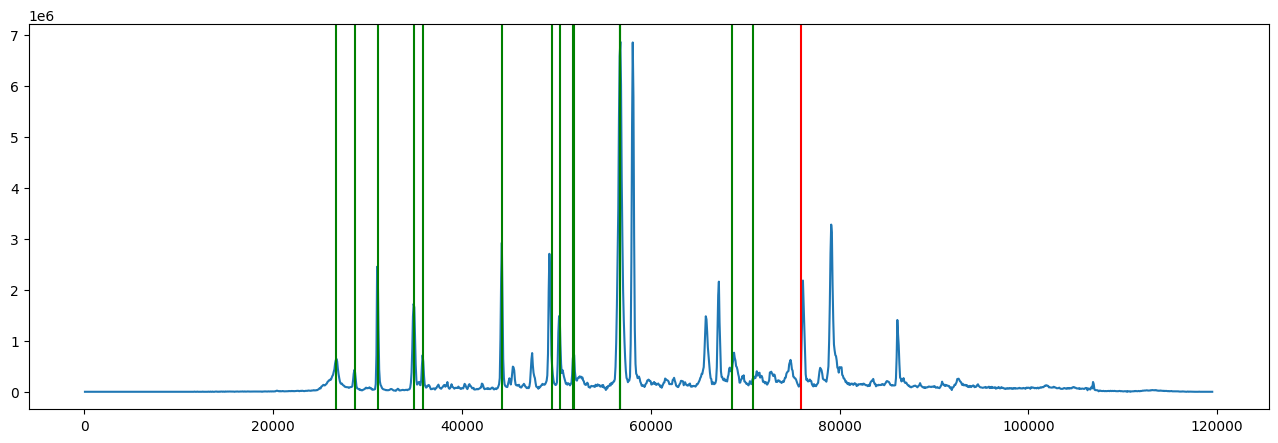

In [200]:
plot_phospho_ions_behaviour_for_spectrum_id_within_mz_range(75897)

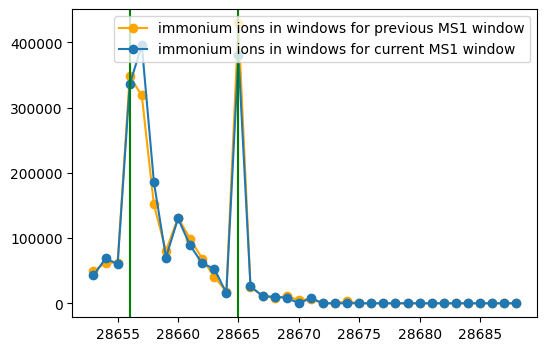

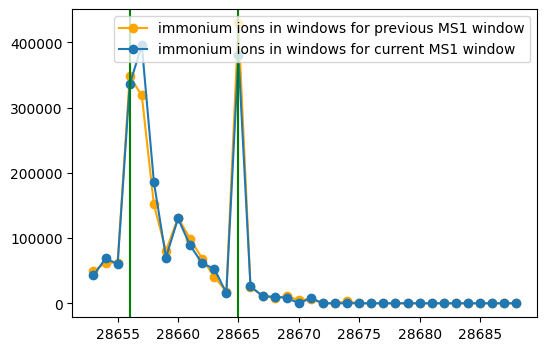

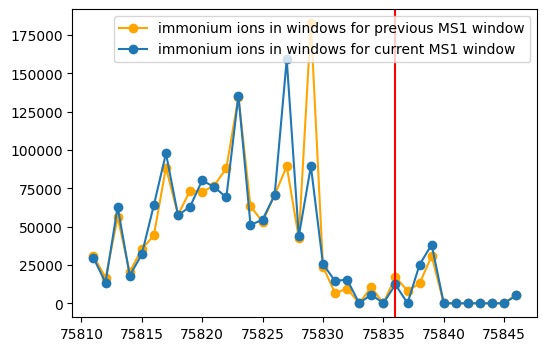

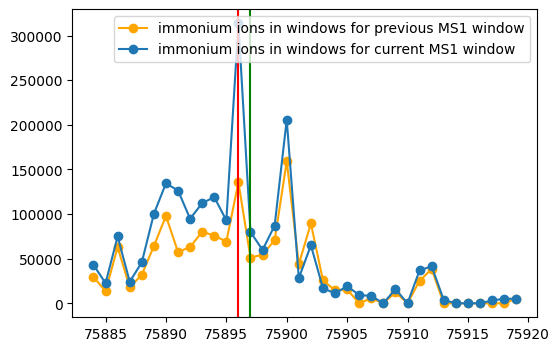

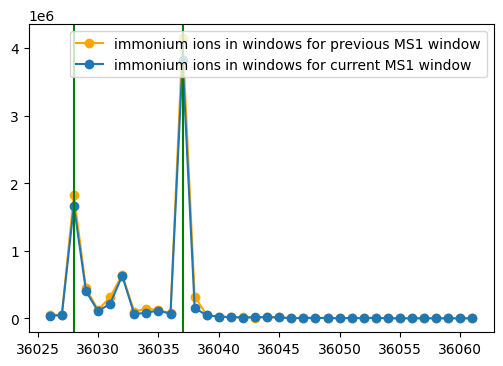

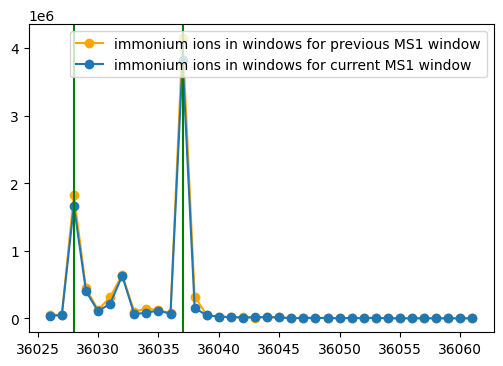

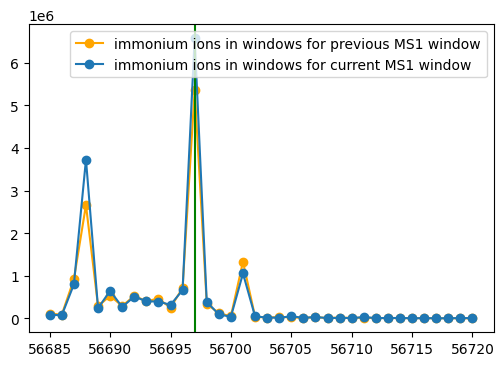

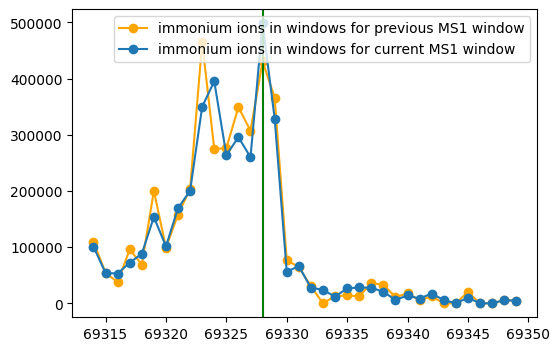

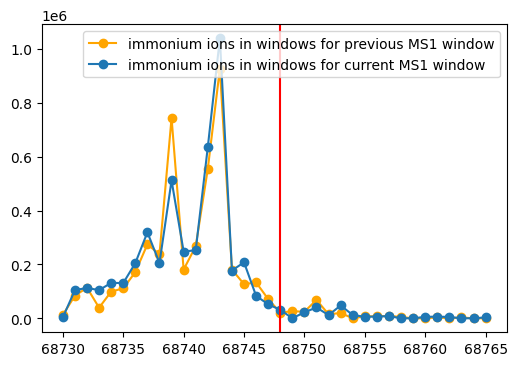

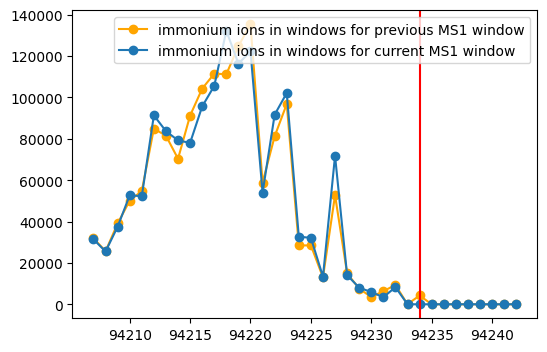

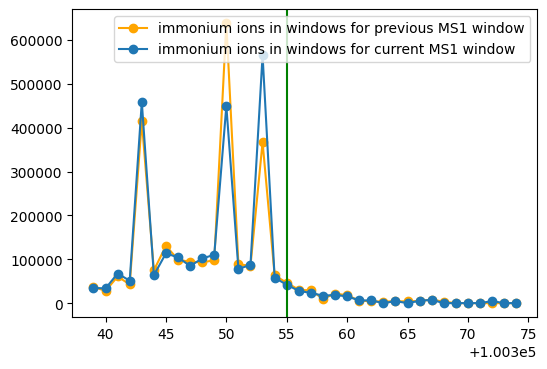

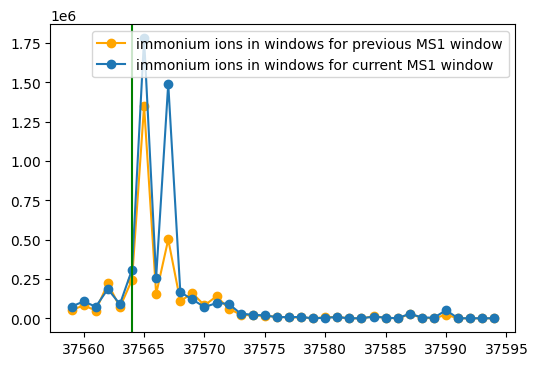

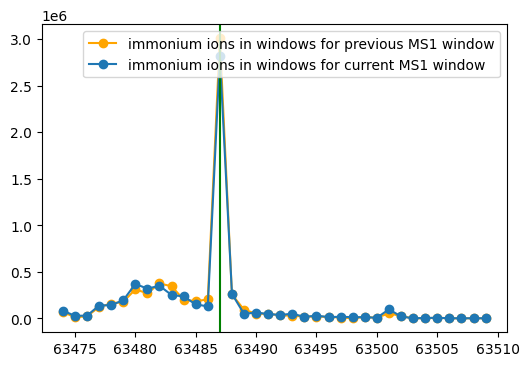

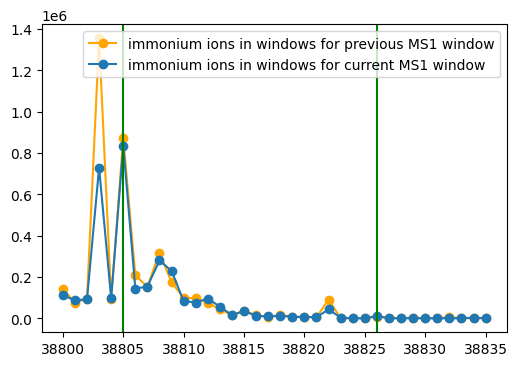

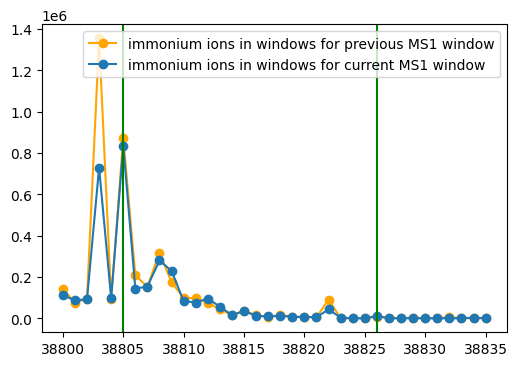

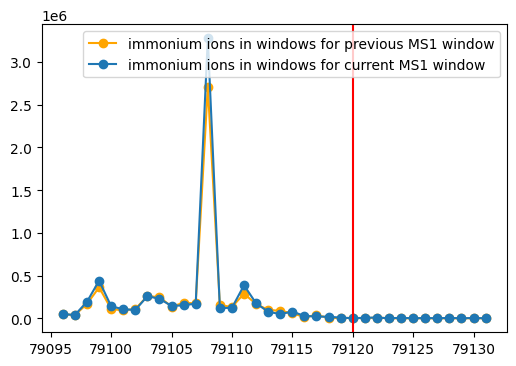

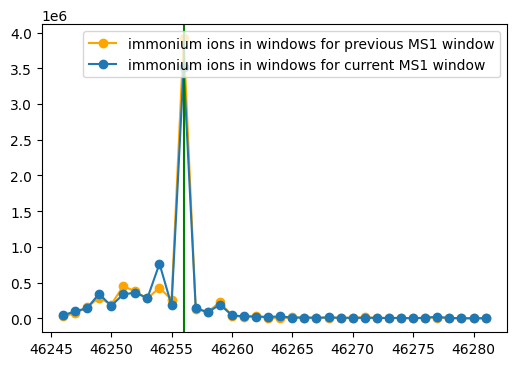

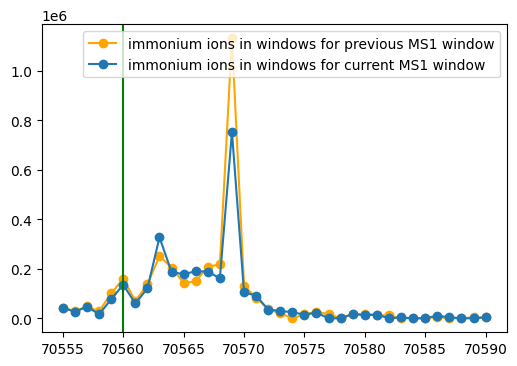

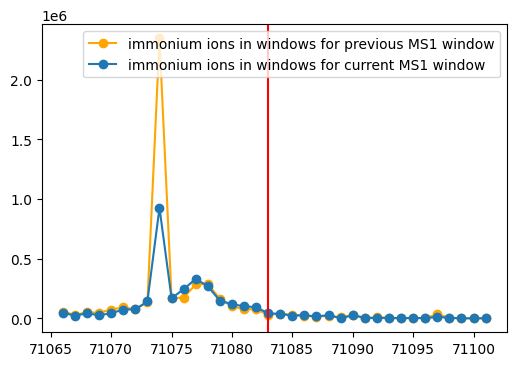

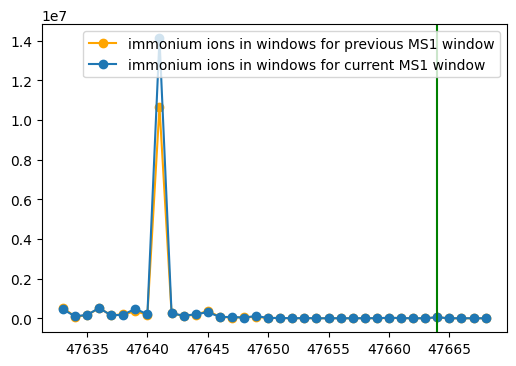

In [56]:
for id in phospho_precursors_all["higher_energy_ids"].to_numpy()[:20]:
    plot_phospho_ions_behaviour_for_spectrum_id_within_ms1_window(id)

In [57]:
plt.close()